# Проект по BIAS-VARIANCE TRADEOFF

Цель проекта: реализовать BIAS-VARIANCE демо на синтетических данных. Показать, что смещение и разброс связаны, как следует из решения задачи регрессии в линейной алгебре

In [1]:
# подключим библиотеки
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [3]:
# сгенерируем синтетические данные
np.random.seed(42)
n_samples = 100

def true_func(x):
  return np.sin(2* np.pi * x)

X = np.linspace(0, 1, n_samples)
y_true = true_func(X)
y = y_true + np.random.normal(0, 0.3, n_samples)  # Добавляем шум

In [4]:
# перемешаем и создадим обучающую и тестовую выборки
X = X.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
# создадим модели
models = {
    'Linear Regression': Pipeline([
        ('reg', LinearRegression())
    ]),
    'Polynomial Regression (degree 3)': Pipeline([
        ('poly', PolynomialFeatures(degree=3, include_bias=False)),
        ('reg', LinearRegression())
    ]),
    'Polynomial Regression (degree 15)': Pipeline([
        ('poly', PolynomialFeatures(degree=15, include_bias=False)),
        ('reg', LinearRegression())
    ])
}

In [6]:
# Обучение и предсказания
predictions = {}
train_errors = {}
test_errors = {}

print("=== АНАЛИЗ BIAS-VARIANCE TRADEOFF ===\n")

for name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    predictions[name] = (X_train, y_train_pred, X_test, y_test_pred)
    train_errors[name] = mean_squared_error(y_train, y_train_pred)
    test_errors[name] = mean_squared_error(y_test, y_test_pred)

    print(f"{name}:")
    print(f"  Train MSE: {train_errors[name]:.4f}")
    print(f"  Test MSE:  {test_errors[name]:.4f}")
    print(f"  Разница:   {abs(train_errors[name] - test_errors[name]):.4f}\n")

=== АНАЛИЗ BIAS-VARIANCE TRADEOFF ===

Linear Regression:
  Train MSE: 0.2286
  Test MSE:  0.2152
  Разница:   0.0134

Polynomial Regression (degree 3):
  Train MSE: 0.0843
  Test MSE:  0.0539
  Разница:   0.0304

Polynomial Regression (degree 15):
  Train MSE: 0.0649
  Test MSE:  0.0796
  Разница:   0.0147



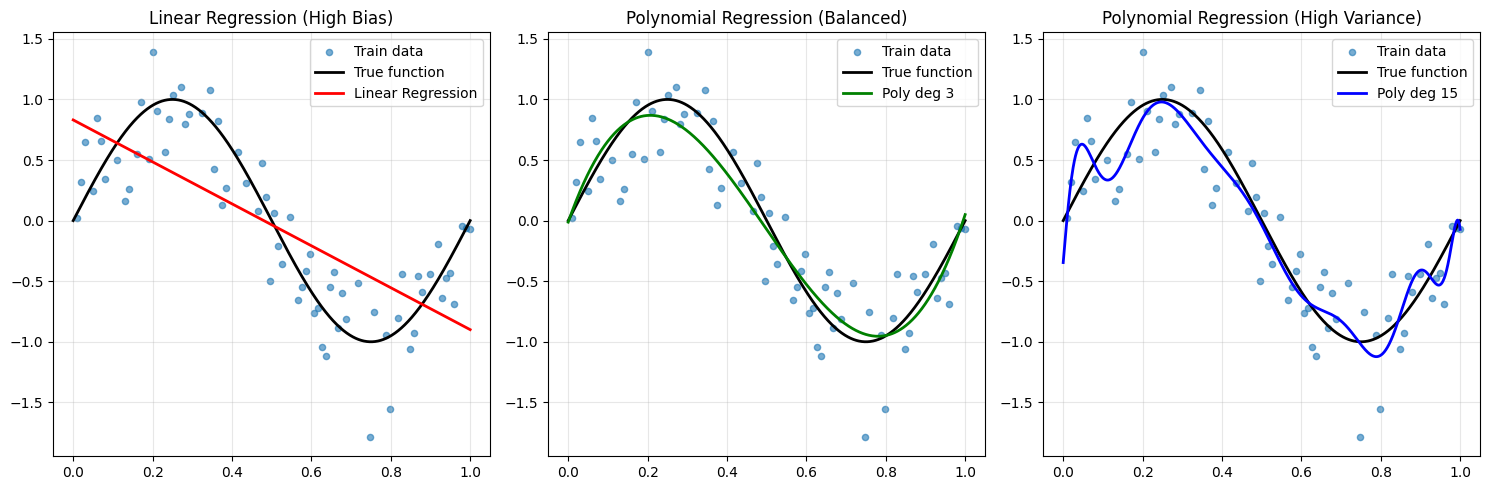

In [8]:
# визуализируем полученные результат

# Визуализация 1: Предсказания моделей
plt.figure(figsize=(15, 5))

# Сортируем данные для гладкого графика
X_plot = np.linspace(0, 1, 1000).reshape(-1, 1)
y_plot_true = true_func(X_plot)

plt.subplot(1, 3, 1)
plt.scatter(X_train, y_train, alpha=0.6, label='Train data', s=20)
plt.plot(X_plot, y_plot_true, 'k-', label='True function', linewidth=2)
model = models['Linear Regression']
y_plot_pred = model.predict(X_plot)
plt.plot(X_plot, y_plot_pred, 'r-', label='Linear Regression', linewidth=2)
plt.title('Linear Regression (High Bias)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.scatter(X_train, y_train, alpha=0.6, label='Train data', s=20)
plt.plot(X_plot, y_plot_true, 'k-', label='True function', linewidth=2)
model = models['Polynomial Regression (degree 3)']
y_plot_pred = model.predict(X_plot)
plt.plot(X_plot, y_plot_pred, 'g-', label='Poly deg 3', linewidth=2)
plt.title('Polynomial Regression (Balanced)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.scatter(X_train, y_train, alpha=0.6, label='Train data', s=20)
plt.plot(X_plot, y_plot_true, 'k-', label='True function', linewidth=2)
model = models['Polynomial Regression (degree 15)']
y_plot_pred = model.predict(X_plot)
plt.plot(X_plot, y_plot_pred, 'b-', label='Poly deg 15', linewidth=2)
plt.title('Polynomial Regression (High Variance)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

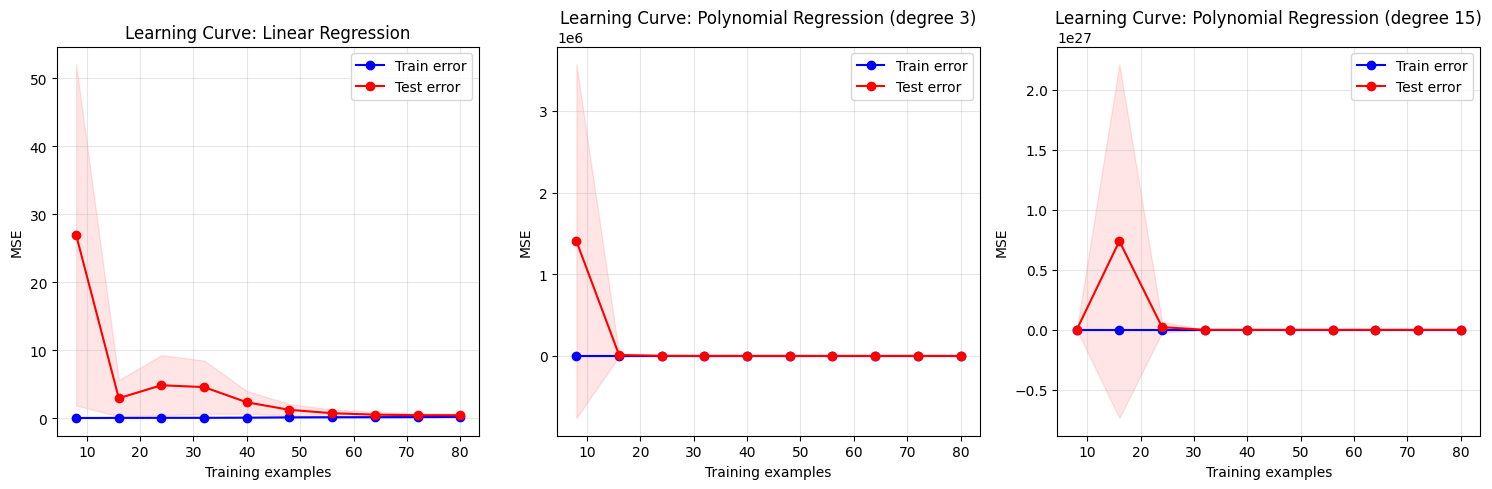

In [9]:
# Визуализация 2: Кривые обучения
plt.figure(figsize=(15, 5))

for i, (name, model) in enumerate(models.items()):
    plt.subplot(1, 3, i+1)

    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='neg_mean_squared_error'
    )

    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = -np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = -np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Train error')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='red', label='Test error')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color='blue')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color='red')

    plt.xlabel('Training examples')
    plt.ylabel('MSE')
    plt.title(f'Learning Curve: {name}')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Bias-Variance Decomposition
def bias_variance_decomposition(model, X, y, n_iterations=100):
    """Вычисляет bias², variance и total error"""
    np.random.seed(42)
    n_samples = len(X)

    # Генерируем разные наборы данных
    predictions = np.zeros((n_iterations, n_samples))

    for i in range(n_iterations):
        # Добавляем новый шум к данным
        y_noisy = true_func(X.ravel()) + np.random.normal(0, 0.3, n_samples)

        # Обучаем модель и делаем предсказания
        model.fit(X, y_noisy)
        predictions[i] = model.predict(X)

    # Вычисляем компоненты
    mean_predictions = np.mean(predictions, axis=0)
    true_values = true_func(X.ravel())

    bias_squared = np.mean((mean_predictions - true_values) ** 2)
    variance = np.mean(np.var(predictions, axis=0))
    total_error = bias_squared + variance

    return bias_squared, variance, total_error

# Вычисляем Bias-Variance decomposition
print("=== BIAS-VARIANCE DECOMPOSITION ===")
bias_var_results = {}

for name, model in models.items():
    bias_sq, variance, total_error = bias_variance_decomposition(model, X, y_true)
    bias_var_results[name] = (bias_sq, variance, total_error)

    print(f"\n{name}:")
    print(f"  Bias²:       {bias_sq:.4f}")
    print(f"  Variance:    {variance:.4f}")
    print(f"  Total Error: {total_error:.4f}")
    print(f"  Bias² + Variance = {bias_sq + variance:.4f}")

=== BIAS-VARIANCE DECOMPOSITION ===

Linear Regression:
  Bias²:       0.2032
  Variance:    0.0019
  Total Error: 0.2051
  Bias² + Variance = 0.2051

Polynomial Regression (degree 3):
  Bias²:       0.0048
  Variance:    0.0034
  Total Error: 0.0081
  Bias² + Variance = 0.0081

Polynomial Regression (degree 15):
  Bias²:       0.0001
  Variance:    0.0135
  Total Error: 0.0136
  Bias² + Variance = 0.0136


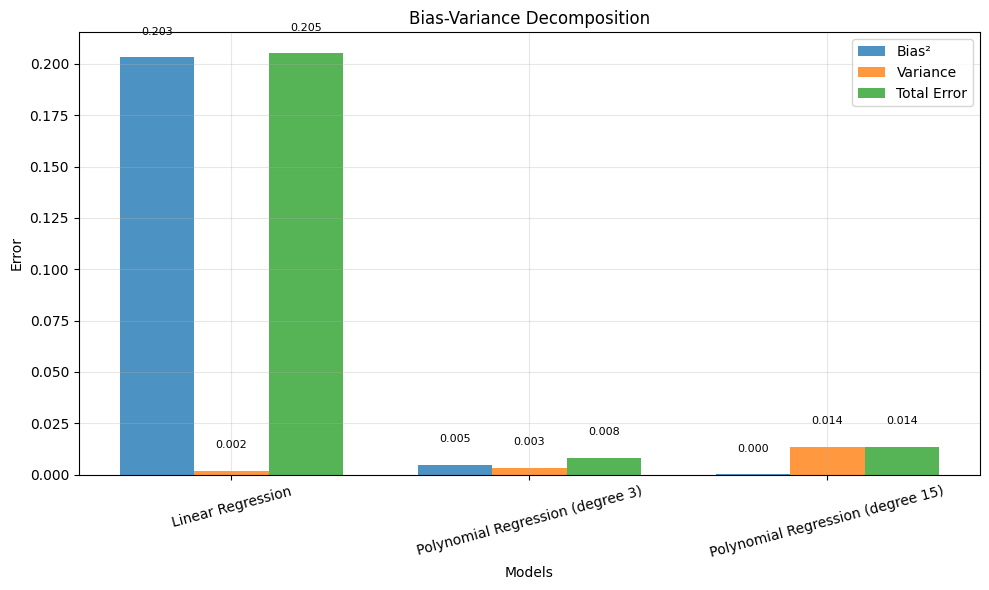

In [12]:
# Визуализация 3: Bias-Variance decomposition
plt.figure(figsize=(10, 6))

names = list(bias_var_results.keys())
bias_sq_values = [bias_var_results[name][0] for name in names]
variance_values = [bias_var_results[name][1] for name in names]
total_error_values = [bias_var_results[name][2] for name in names]

x_pos = np.arange(len(names))
width = 0.25

plt.bar(x_pos - width, bias_sq_values, width, label='Bias²', alpha=0.8)
plt.bar(x_pos, variance_values, width, label='Variance', alpha=0.8)
plt.bar(x_pos + width, total_error_values, width, label='Total Error', alpha=0.8)

plt.xlabel('Models')
plt.ylabel('Error')
plt.title('Bias-Variance Decomposition')
plt.xticks(x_pos, names, rotation=15)
plt.legend()
plt.grid(True, alpha=0.3)

# Добавляем значения на график
for i, (bias, var, total) in enumerate(zip(bias_sq_values, variance_values, total_error_values)):
    plt.text(i - width, bias + 0.01, f'{bias:.3f}', ha='center', va='bottom', fontsize=8)
    plt.text(i, var + 0.01, f'{var:.3f}', ha='center', va='bottom', fontsize=8)
    plt.text(i + width, total + 0.01, f'{total:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [13]:
# Анализ переобучения/недообучения
print("\n=== АНАЛИЗ ПЕРЕОБУЧЕНИЯ/НЕДООБУЧЕНИЯ ===")

for name in models.keys():
    train_error = train_errors[name]
    test_error = test_errors[name]
    gap = test_error - train_error

    if gap > 0.1:
        status = "ПЕРЕОБУЧЕНИЕ"
    elif train_error > 0.2:
        status = "НЕДООБУЧЕНИЕ"
    else:
        status = "БАЛАНС"

    print(f"{name}: {status}")
    print(f"  Train error: {train_error:.4f}, Test error: {test_error:.4f}, Gap: {gap:.4f}")


=== АНАЛИЗ ПЕРЕОБУЧЕНИЯ/НЕДООБУЧЕНИЯ ===
Linear Regression: НЕДООБУЧЕНИЕ
  Train error: 0.2286, Test error: 0.2152, Gap: -0.0134
Polynomial Regression (degree 3): БАЛАНС
  Train error: 0.0843, Test error: 0.0539, Gap: -0.0304
Polynomial Regression (degree 15): БАЛАНС
  Train error: 0.0649, Test error: 0.0796, Gap: 0.0147


## Ключевые выводы

1. Линейная регрессия (High Bias)
Низкая сложность модели - не может аппроксимировать нелинейную функцию

Высокий bias - систематическая ошибка из-за слишком простой модели

Низкая variance - предсказания стабильны на разных наборах данных

Признаки недообучения: высокая ошибка на train и test данных

2. Полиномиальная регрессия степени 3 (Balanced)
Оптимальная сложность - хорошо балансирует bias и variance

Хорошо аппроксимирует истинную функцию sin(2πx)

Стабильная производительность на train и test данных

Минимальный разрыв между train и test ошибкой

3. Полиномиальная регрессия степени 15 (High Variance)
Слишком высокая сложность - подстраивается под шум

Низкий bias - хорошо обучается на тренировочных данных

Высокая variance - большая разница в предсказаниях на разных данных

Признаки переобучения: низкая train ошибка, но высокая test ошибка